#실습 1
- 뉴스 + tm = DTM 생성

1. 수집대상 뉴스 검색 및 제목 저장

In [ ]:
from bs4 import BeautifulSoup
from lxml import etree
from urllib import parse
import requests
import urllib.request
import urllib.parse
import numpy as np
import pandas as pd
import time

#----------------------------------------------#
#변경할 부분
startdate = "2022.04.16"
enddate = "2022.04.30"
searchword ="전기차"#검색어
#----------------------------------------------#

base_url = "https://search.naver.com/search.naver?where=news&sm=tab_pge&query"+parse.urlencode([('',searchword)], doseq=True)+"&sort=1&photo=3&field=0&pd=3&ds="+startdate+"&de="+enddate+"&mynews=1&office_type=0&office_section_code=0&news_office_checked=&nso=so:dd,p:from"+startdate.replace(".", "")+"to"+enddate.replace(".", "")+",a:all&mynews=0&start="
titles = [ ]
urls = [ ]
i=1

while True:
 try:
    time.sleep(0.45)
    url = base_url+str(i)
    html = urllib.request.urlopen(url).read()
    soup = BeautifulSoup(html, 'html.parser')
    t_news = soup.select('a.news_tit')  #클래스 표시
    t_len = len(t_news)

    if t_len <1:
        break

    for j in np.arange(t_len)+1:
            try: 
                titles.append(soup.select('a.news_tit')[j].text)
                urls.append(soup.select('a.info')[j]['href'])
            except Exception as e:
                continue
    i=i+10
    
 except Exception as e:
    continue

result = pd.DataFrame({"Url": urls, "Title":titles})
result.Url[0]

'https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=105&oid=023&aid=0003688540'

2. 본문 수집

In [ ]:
articles = []
dates = []

for i in result.Url: 
   try:
    if( "news.naver.com" in i ): #바뀐곳
     print(i)
     time.sleep(0.45)
     html = urllib.request.urlopen(i).read()
     soup = BeautifulSoup(html, 'html.parser')

     news = soup.select('div#dic_area')[0].text #id #, class.
     news_date = soup.select('span.media_end_head_info_datestamp_time._ARTICLE_DATE_TIME')[0].text  #네이버 뉴스의 날짜 시간 부분 지정

     articles.append(news)
     dates.append(news_date.split()[0])

   except Exception as e:
    print(e)
    continue


https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=105&oid=023&aid=0003688540
https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=110&oid=020&aid=0003425728
https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=102&oid=353&aid=0000042135
https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=101&oid=009&aid=0004957385
https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=102&oid=022&aid=0003691184
https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=103&oid=015&aid=0004692436
https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=101&oid=277&aid=0005081994
https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=101&oid=016&aid=0001984789
https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=105&oid=016&aid=0001984778
https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=101&oid=016&aid=0001984767
https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=101&oid=020&aid=0003425570
https://news.naver.com/main/read

In [ ]:
# 수집된 내용을 표로 정리하기, news컬럼, date컬럼, likes컬럼
df = pd.DataFrame({'news':articles, 'date':dates})
df

3. NLP 및 데이터셋 만들기

In [ ]:
!pip install konlpy

from konlpy.tag import Okt
okt = Okt() #Kkma, Hannanum....
okt.nouns( articles[0] )  #수집된 첫번째 기사에 대한 명사 

def tokenizer(text):  #함수를 만드는 부분
    # 입력 인자로 들어온 text 를 형태소 단어로 토큰화 하여 list 객체 반환
    tokens_ko = okt.nouns(text) #nouns를 morphs로 바꾸면 명사외에도...
    return tokens_ko


     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 448 kB 55.4 MB/s 


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tf_vect = TfidfVectorizer(tokenizer=tokenizer, 
                          #바뀐곳-stop_words로 잡힌 단어를 제거
                          stop_words=['건','악','최', '초','총',
                          '탈', '폭'], 
                          #바뀐곳-0~1사이의 값, 단어
                          min_df=0.1)  
#단어들이 최소 전체의 10% 문서에서 나오는 것만 DTM에 사용
#많은 문서에 나오는 단어를 사용
dtm = tf_vect.fit_transform( df.news ) 
dtm


<81x371 sparse matrix of type '<class 'numpy.float64'>'
	with 6304 stored elements in Compressed Sparse Row format>

In [ ]:
tf_vect.vocabulary_

In [ ]:
df2 = pd.DataFrame(dtm.todense())
df2

0         1         2         3         4         5         6    \
0   0.000000  0.000000  0.000000  0.000000  0.000000  0.091109  0.000000   
1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2   0.231788  0.038631  0.086845  0.000000  0.048702  0.000000  0.034326   
3   0.000000  0.000000  0.085416  0.087703  0.000000  0.000000  0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
..       ...       ...       ...       ...       ...       ...       ...   
76  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
77  0.454180  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
78  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
79  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
80  0.166683  0.125012  0.000000  0.000000  0.000000  0.048093  0.000000   

         7         8        9    ...       361       362       363       364  \
0   0.000000  0.000000  0.00000  ...  0.000000  0.080676  0.000000  0.088733   
1   0.000000  0.000000  0.00000  ...  0.000000  0.000000  0.000000  0.000000   
2   0.000000  0.044585  0.00000  ...  0.000000  0.000000  0.000000  0.000000   
3   0.000000  0.000000  0.00000  ...  0.000000  0.000000  0.140190  0.000000   
4   0.000000  0.000000  0.00000  ...  0.084741  0.000000  0.000000  0.101281   
..       ...       ...      ...  ...       ...       ...       ...       ...   
76  0.000000  0.000000  0.00000  ...  0.000000  0.000000  0.000000  0.000000   
77  0.000000  0.000000  0.00000  ...  0.000000  0.000000  0.000000  0.000000   
78  0.113401  0.000000  0.00000  ...  0.126895  0.091927  0.041486  0.000000   
79  0.124728  0.000000  0.00000  ...  0.046523  0.101110  0.045630  0.000000   
80  0.000000  0.048093  0.05092  ...  0.000000  0.000000  0.000000  0.000000   

    365       366  367       368       369       370  
0   0.0  0.000000  0.0  0.000000  0.000000  0.000000  
1   0.0  0.000000  0.0  0.000000  0.000000  0.000000  
2   0.0  0.000000  0.0  0.000000  0.000000  0.000000  
3   0.0  0.000000  0.0  0.079424  0.000000  0.000000  
4   0.0  0.172887  0.0  0.000000  0.000000  0.000000  
..  ...       ...  ...       ...       ...       ...  
76  0.0  0.000000  0.0  0.000000  0.000000  0.000000  
77  0.0  0.000000  0.0  0.000000  0.000000  0.000000  
78  0.0  0.043148  0.0  0.000000  0.000000  0.056700  
79  0.0  0.237290  0.0  0.000000  0.000000  0.062364  
80  0.0  0.000000  0.0  0.000000  0.046839  0.000000  

[81 rows x 371 columns]

In [ ]:
#DTM과 다른 정보들을 한 표에 정리
df3 = pd.concat([df.date, df.likes, df2], axis=1)
#axis=0 길쭉하게 한 표로, axis=1 옆으로 추가해서 한 표로 정리

df3.to_csv("news.csv")

#실습2
- 폴더 내 파일 처리

1. 데이터 읽기

In [ ]:
!unzip news_small.zip
#!unzip news.zip

In [ ]:
import os
import pandas as pd

files1 = os.listdir('103')   #압축이 풀린 103폴더의 파일들을 읽음
files2 = os.listdir('105')   #압축이 풀린 105폴더의 파일들을 읽음


In [ ]:
y = []
x = []

#txt파일을 읽어서 파일 내용을 x라는 리스트에 추가
def add_file(path):
    with open(path, "r", encoding="utf-8") as f:
        s = f.read()
        x.append(s)



In [ ]:
#반복문, 똑같은 작업을 여러 대상에 적용
for f in files1:  #파일갯수만큼 반복
     add_file("103/"+f) #103폴더 신문기사가 X에 추가
     y.append(0)#103폴더 신문기사만큼 y에 0값을 추가, 0은 103을 나타내는 범주

for f in files2:
     add_file("105/"+f)
     y.append(1)  #105를 나타내는 범주 1

In [ ]:
len(y)

400

In [ ]:
df = pd.DataFrame( {'label':y, 'articles':x })

In [ ]:
df

2. 데이터 파티셔닝

In [ ]:
print( df['label'].value_counts( ) )  #label 컬럼의 범주별 빈도
print( df.info() )

0    200
1    200
Name: label, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     400 non-null    int64 
 1   articles  400 non-null    object
dtypes: int64(1), object(1)
memory usage: 6.4+ KB
None


In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split( df, test_size=0.2)

3. 토크나이저 만들기 (명사만 추출)

In [ ]:
!pip install konlpy
from konlpy.tag import Okt
morphs = Okt()
def token(text):
    tokens_ko = morphs.nouns(text)
    return tokens_ko

token(df['articles'][0])  

4. Tfidf로 DTM 만들기

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf_vect = TfidfVectorizer(tokenizer=token, min_df=10)
tfidf_vect.fit(train_df['articles'])  #train의 명사를 뽑은 것까지


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


TfidfVectorizer(min_df=10, tokenizer=<function token at 0x7f9c7a235b00>)

In [ ]:
tfidf_matrix_train = tfidf_vect.transform(train_df['articles'])
tfidf_matrix_test = tfidf_vect.transform(test_df['articles'])

In [ ]:
tfidf_matrix_test

<80x1435 sparse matrix of type '<class 'numpy.float64'>'
	with 9995 stored elements in Compressed Sparse Row format>

5.  모델링

In [ ]:
#RF 이용하여 감성 분석 Classification 수행. 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#n_estimators: RF에 들어가는 tree의 개수
rf = RandomForestClassifier(random_state=0, n_estimators=1000)  
rf.fit(tfidf_matrix_train , train_df['label']  )  #모델링
preds1 = rf.predict(tfidf_matrix_test) #테스트셋으로 감성예측
print('Accuracy: ',accuracy_score(test_df['label'],preds1))#정답율

Accuracy:  0.85


다른 모형과 비교

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

dt1 = tree.DecisionTreeClassifier()
dt1 = dt1.fit(tfidf_matrix_train , train_df['label'])
dt1.feature_importances_
preds2 = dt1.predict( tfidf_matrix_test )
print('Accuracy: ',accuracy_score(test_df['label'],preds2))#정답율

clf = MultinomialNB().fit(tfidf_matrix_train , train_df['label'])
preds3 = clf.predict(tfidf_matrix_test)
print('Accuracy: ',accuracy_score(test_df['label'],preds3))#정답율

lr_clf = LogisticRegression()
lr_clf.fit(tfidf_matrix_train , train_df['label'])
preds4 = lr_clf.predict(tfidf_matrix_test)
print('Accuracy: ',accuracy_score(test_df['label'],preds4))#정답율


Accuracy:  0.775
Accuracy:  0.8375
Accuracy:  0.8875


#실습3: 감성분석 및 시각화, 군집
1. 데이터 처리 및 DTM 생성

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.1 MB/s 
     |████████████████████████████████| 448 kB 48.9 MB/s 


In [ ]:
!wget https://github.com/rickiepark/python-machine-learning-book-3rd-edition/raw/master/ch08/ratings_train.txt -O ratings_train.txt
!wget https://github.com/rickiepark/python-machine-learning-book-3rd-edition/raw/master/ch08/ratings_train.txt -O ratings_test.txt

--2022-05-04 01:35:44--  https://github.com/rickiepark/python-machine-learning-book-3rd-edition/raw/master/ch08/ratings_train.txt
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/python-machine-learning-book-3rd-edition/master/ch08/ratings_train.txt [following]
--2022-05-04 01:35:44--  https://raw.githubusercontent.com/rickiepark/python-machine-learning-book-3rd-edition/master/ch08/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘ratings_train.txt’

ratings_train.txt   100%[===================>]  13.95M  --.-KB/s    in 0.09s 

In [ ]:
import pandas as pd

train_df = pd.read_csv('ratings_test.txt', sep='\t')#탭으로 값이 구분된 파일
print(train_df.shape)
train_df = train_df.iloc[0:1000, :] 
train_df.head(7)


(150000, 3)


id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1
5   5403919      막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.      0
6   7797314                              원작의 긴장감을 제대로 살려내지못했다.      0

In [ ]:
from konlpy.tag import Okt
twitter = Okt() #open korean text 형태소분석기
def tw_tokenizer(text):
    tokens_ko = twitter.nouns(text) #명사만 추출
    return tokens_ko

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(tokenizer=tw_tokenizer, min_df=5 )
tfidf_vect.fit(train_df['document'])  #train의 명사를 뽑은 것까지
tfidf_matrix_train = tfidf_vect.transform(train_df['document'])


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


In [ ]:
tfidf_vect.vocabulary_.keys()

dict_keys(['진짜', '보고', '영화', '줄', '연기', '재미', '평점', '정말', '드라마', '사람', '볼', '때', '그', '것', '감동', '그냥', '왜', '점', '다시', '완전', '시간', '내', '이', '최고', '내용', '하나', '또', '배우', '사랑', '감독', '말', '느낌', '생각', '주인공', '좀', '작품', '더', '뭐'])

2. DTM의 단어들만 추출하여 워드클라우드를 만들기

In [ ]:
words = str( list( tfidf_vect.vocabulary_.keys() ) )
words

"['진짜', '포스터', '보고', '영화', '줄', '연기', '추천', '이야기', '재미', '평점', '의', '막', '움', '원작', '긴장감', '별', '욕', '정말', '드라마', '사람', '액션', '꽤', '볼', '데', '자극', '멜로', '손', '때', '그', '것', '가장', '감동', '임', '스토리', '코', '그냥', '이해', '왜', '갈수록', '이건', '캐스팅', '위', '놈', '절대', '걸', '나름', '듯', '건', '도', '별로', '수작', '수', '꼭', '연출', '점', '다시', '한번', '남', '완전', '쓰레기', '시간', '내', '이', '인생', '최고', '대한', '대체', '정신', '매력', '내용', '하나', '또', '배우', '음악', '조금', '돈', '공감', '안', '캐릭터', '초반', '수준', '알', '난', '우리', '사랑', '속', '제일', '용', '웃음', '감독', '말', '맛', '가슴', '자체', '저', '무슨', '혼자', '전', '기분', '느낌', '생각', '주인공', '모습', '짜증', '전개', '좀', '감정', '대해', '노력', '작품', '시청률', '이제', '연기력', '일본', '졸작', '더', '결말', '실망', '뭐', '뭘', '개', '기대', '가요', '눈', '최악', '인상', '설정', '대박', '진심', '못', '요', '처음', '로맨스', '아주', '명작', '소재', '끌', '몰입', '실감', '후', '또한', '전혀', '나', '당시', '잼', '보기', '정도', '마지막', '나이', '답', '여운', '역시', '자신', '한국', '만', '요즘', '막장', '코미디', '장면', '끝', '이유', '알바', '남자', '애', '보지', '티비', '거', '추억', '이영화', '보', '물', '시리즈', '중', '표

- colab에 폰트 파일을 업로드 

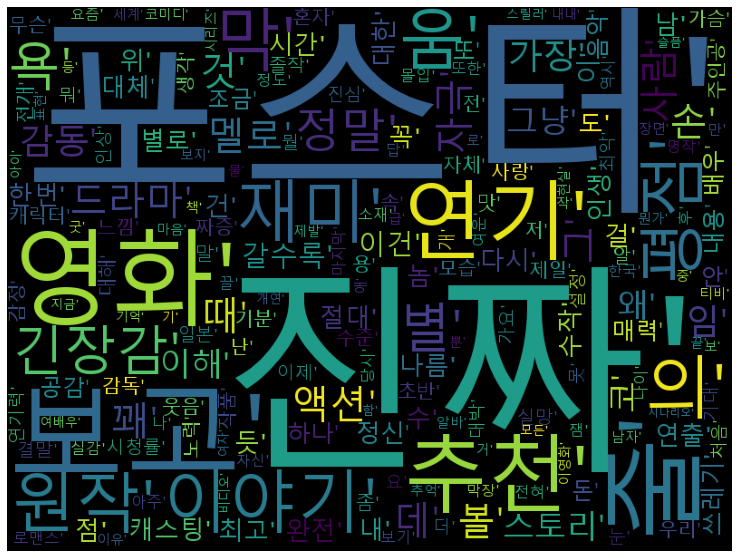

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#malgun.ttf를 업로드
wordcloud = WordCloud(font_path='malgun.ttf', background_color = "black", width = 800, height = 600).generate(words)
plt.figure(figsize = (15, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


3. 유사도 계산해보기

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity(tfidf_matrix_train[30,:] , tfidf_matrix_train[100,:]))
print(train_df.document[30])
print(train_df.document[100])

print(cosine_similarity(tfidf_matrix_train[30,:] , tfidf_matrix_train[30,:]))

[[0.19477086]]
엄포스의 위력을 다시 한번 깨닫게 해준 적.남 꽃검사님도 연기 정말 좋았어요! 완전 명품드라마!
신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다.
[[1.]]


In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
euclidean_distances(tfidf_matrix_train[30,:] , tfidf_matrix_train[100,:])
euclidean_distances(tfidf_matrix_train[100,:] , tfidf_matrix_train[100,:])
euclidean_distances(tfidf_matrix_train[30,:] , tfidf_matrix_train)

In [ ]:
from sklearn.metrics import jaccard_score
import numpy as np

binary = np.array( [ [0,1,1,1,1], [1, 1, 1, 1,0]])

jaccard_score(binary[0,:] , binary[1,:])

0.6

4. 군집분석
- k-means

In [ ]:
from sklearn.cluster import KMeans

# 5개 집합으로 군집화 수행. 예제를 위해 동일한 클러스터링 결과 도출용 random_state=0 
km_cluster = KMeans(n_clusters=4)
km_cluster.fit(tfidf_matrix_train)  #DTM을 입력으로 넣음
cluster_label = km_cluster.labels_
cluster_label #각각의 document가 몇번 군집인지를 알려주는 결과

cluster_centers = km_cluster.cluster_centers_#각 군집이 갖는 38개 단어 tfidf의 평균
#군집별 특성을 확인
np.argmax( cluster_centers[1,:])  #군집별로 평균 tfidf가 가장 높은 단어를 확인

#print(cluster_centers)
np.argmax( cluster_centers[1,:])  #군집별로 평균 tfidf가 가장 높은 단어를 확인


133

In [ ]:
print( train_df.document[0])
print( train_df.document[2])

아 더빙.. 진짜 짜증나네요 목소리
너무재밓었다그래서보는것을추천한다


In [ ]:
train_df['cluster_label'] = cluster_label
train_df.head()

In [ ]:
from sklearn.cluster import KMeans

# 3개의 집합으로 군집화 
km_cluster = KMeans(n_clusters=3) #군집의 갯수 지정
km_cluster.fit(tfidf_matrix_train)
cluster_label = km_cluster.labels_


# 소속 클러스터를 cluster_label 컬럼으로 할당하고 cluster_label 값으로 정렬
train_df['cluster_label'] = cluster_label
train_df.sort_values(by='cluster_label')

id                                           document  label  \
0     9976970                                아 더빙.. 진짜 짜증나네요 목소리      0   
315   8830133                                 아 츠무구만 없어지면 별 5개줄게      0   
314   9360766       많은생각을 하게 됐습니다. 예뼈지고 싶은 맘은 있었지만 과하면 독이겠네요. ^^      1   
313   8520381  곤사토시 감독... 2010년 안타깝게 돌아가셔서 가슴이 먹먹합니다.. 정말 천재적...      1   
312    214940                          잊을 수 없는 안개낀 워터루 다리와 마스코트.      1   
..        ...                                                ...    ...   
44    8548510  윤제문이라는 멋진 배우를 발견하게 됐어요. 소소한 일탈이 잔잔한 미소를 머금게 합니...      1   
387  10232830  림프비즈킷의 OST만 10점. 개봉 당시 극장에서 봤는데 영화내내 오우삼 쥑이고 싶...      0   
78    7884025  한국영화 흥행코드: 갈등-갈등-계~에속 갈등-화해-감동- 평점 10점 남발- 흥행 ...      0   
263   6931068               필름값이 아깝다..재미 더럽게없다..2점부터 점수준것들 매미 OO      0   
499   9600841                    자동차 매니아인 나의 평점은 5점 이하~속았다...아오~      0   

     cluster_label  
0                0  
315              0  
314              0  
313              0  
312              0  
..             ...  
44               2  
387              2  
78               2  
263              2  
499              2  

[500 rows x 4 columns]

In [ ]:
cluster_centers = km_cluster.cluster_centers_
print('cluster_centers shape :',cluster_centers.shape)
print(cluster_centers)

cluster_centers shape : (3, 38)
[[0.02162234 0.01888703 0.02804081 0.01599812 0.02103662 0.02639393
  0.02063558 0.01381332 0.01302035 0.01985272 0.02069286 0.01510443
  0.01832173 0.02214814 0.01945078 0.02140421 0.02536498 0.01612536
  0.02328878 0.0114109  0.0192502  0.01985916 0.04558067 0.03448599
  0.01837682 0.02395451 0.03220016 0.0188741  0.01968561 0.00095307
  0.05101286 0.02243804 0.02061664 0.01210284 0.03379679 0.02777228
  0.01614779 0.01591662]
 [0.00893599 0.03456015 0.         0.         0.02225832 0.01545748
  0.02288731 0.02078887 0.0059695  0.02364334 0.         0.02107672
  0.00611226 0.02230409 0.         0.         0.02441607 0.01214073
  0.00550572 0.01627523 0.00444832 0.03242388 0.04047475 0.72513209
  0.         0.0088094  0.03149381 0.00884473 0.01815539 0.
  0.03359921 0.01734257 0.00598335 0.01212939 0.03517838 0.04141912
  0.01314494 0.02326206]
 [0.         0.02576664 0.02161592 0.         0.         0.
  0.         0.         0.         0.         0.  

- 영화리뷰 테스트셋에서 1000개의 리뷰를 대상으로
- Okt로 명사만 출력을 해서 (min_df=5)
- 워드 클라우드 그리시고
- kmeans 군집을 수행하세요(k=4)
- 각 군집의 특성을 파악해보세요.

- Hierarchical Clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering
hclust = AgglomerativeClustering(linkage='ward', n_clusters=10)
#linkage ward, complete, average, 기본값은 ward (ward는 거리가 euclidean에서 가능)
hclust.fit(tfidf_matrix_train.todense())
hclust.labels_	#각 자료에 대한 클러스터 결과

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


array([3, 1, 0, 4, 2, 7, 0, 2, 4, 4, 3, 0, 1, 1, 1, 0, 1, 4, 6, 0, 0, 0,
       4, 7, 0, 0, 0, 0, 0, 9, 2, 1, 4, 4, 5, 0, 2, 0, 0, 4, 7, 0, 4, 4,
       9, 4, 1, 4, 1, 0, 1, 0, 0, 0, 0, 0, 5, 1, 7, 0, 0, 1, 0, 0, 5, 1,
       0, 9, 7, 3, 7, 0, 0, 1, 0, 7, 0, 0, 9, 0, 0, 5, 0, 0, 6, 5, 0, 0,
       0, 1, 7, 0, 0, 0, 7, 0, 7, 0, 3, 4, 1, 0, 1, 0, 0, 8, 0, 7, 0, 4,
       7, 0, 1, 0, 0, 0, 0, 0, 0, 7, 1, 0, 0, 9, 0, 0, 4, 1, 2, 7, 0, 1,
       0, 7, 0, 6, 0, 0, 1, 0, 0, 2, 1, 4, 0, 3, 1, 3, 4, 1, 8, 0, 2, 0,
       7, 6, 4, 4, 4, 9, 0, 7, 7, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 4,
       0, 6, 1, 0, 1, 1, 1, 0, 0, 0, 0, 9, 8, 0, 5, 0, 7, 0, 1, 1, 0, 1,
       4, 1, 0, 0, 1, 1, 1, 0, 6, 0, 6, 7, 1, 0, 1, 5, 0, 0, 4, 4, 0, 7,
       1, 4, 1, 2, 0, 0, 0, 1, 1, 0, 1, 0, 3, 2, 0, 0, 8, 8, 0, 2, 0, 0,
       1, 0, 0, 0, 1, 0, 3, 4, 0, 0, 3, 2, 7, 0, 0, 0, 7, 7, 1, 4, 3, 9,
       4, 7, 0, 9, 0, 7, 7, 0, 4, 0, 1, 0, 2, 4, 0, 0, 1, 2, 0, 0, 0, 4,
       1, 0, 1, 0, 4, 0, 1, 4, 7, 0, 2, 6, 4, 2, 7,

# 실습 4: 뉴스+tm+topic
-lda 기본 활용

1. 수집대상 뉴스 검색 및 제목 저장

In [ ]:
from bs4 import BeautifulSoup
from lxml import etree
from urllib import parse
import requests
import urllib.request
import urllib.parse
import numpy as np
import pandas as pd
import time

#----------------------------------------------#
#변경할 부분
startdate = "2022.04.16"
enddate = "2022.04.30"
searchword ="전기차"#검색어
#----------------------------------------------#

base_url = "https://search.naver.com/search.naver?where=news&sm=tab_pge&query"+parse.urlencode([('',searchword)], doseq=True)+"&sort=1&photo=3&field=0&pd=3&ds="+startdate+"&de="+enddate+"&mynews=1&office_type=0&office_section_code=0&news_office_checked=&nso=so:dd,p:from"+startdate.replace(".", "")+"to"+enddate.replace(".", "")+",a:all&mynews=0&start="
titles = [ ]
urls = [ ]
i=1

while True:
 try:
    time.sleep(0.45)
    url = base_url+str(i)
    html = urllib.request.urlopen(url).read()
    soup = BeautifulSoup(html, 'html.parser')
    t_news = soup.select('a.news_tit')  #클래스 표시
    t_len = len(t_news)

    if t_len <1:
        break

    for j in np.arange(t_len)+1:
            try: 
                titles.append(soup.select('a.news_tit')[j].text)
                urls.append(soup.select('a.info')[j]['href'])
            except Exception as e:
                continue
    i=i+10
    
 except Exception as e:
    continue

result = pd.DataFrame({"Url": urls, "Title":titles})
result.Url[0]

'https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=105&oid=023&aid=0003688540'

2. 본문 수집

In [ ]:
articles = []
dates = []

for i in result.Url: 
   try:
    if( "news.naver.com" in i ): #바뀐곳
     print(i)
     time.sleep(0.45)
     html = urllib.request.urlopen(i).read()
     soup = BeautifulSoup(html, 'html.parser')

     news = soup.select('div#dic_area')[0].text #id #, class.
     news_date = soup.select('span.media_end_head_info_datestamp_time._ARTICLE_DATE_TIME')[0].text  #네이버 뉴스의 날짜 시간 부분 지정

     articles.append(news)
     dates.append(news_date.split()[0])

   except Exception as e:
    print(e)
    continue


https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=105&oid=023&aid=0003688540
https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=110&oid=020&aid=0003425728
https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=102&oid=353&aid=0000042135
https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=101&oid=009&aid=0004957385
https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=102&oid=022&aid=0003691184
https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=103&oid=015&aid=0004692436
https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=101&oid=277&aid=0005081994
https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=101&oid=016&aid=0001984789
https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=105&oid=016&aid=0001984778
https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=101&oid=016&aid=0001984767
https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=101&oid=020&aid=0003425570
https://news.naver.com/main/read

In [ ]:
# 수집된 내용을 표로 정리하기, news컬럼, date컬럼, likes컬럼
df = pd.DataFrame({'news':articles, 'date':dates})
df

In [ ]:
df.news.str

3. 전처리 및 명사 추출

In [ ]:
!pip install konlpy
!pip install tqdm #진행상태를 알려주는 기능 제공

import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm

print(df.isnull().values.any()) #null값이 있는지 체크
train_data = df.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

train_data['news'] = train_data['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

False
False


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
train_data.news

0      년만에 분기 손실 메타도 순이익  줄어코로나 이후 매 분기 실적 신기록을 갈아치웠던...
1      세계화 시대 저물며 국가기업 역할 재설정생각을 바꿔 새로운 민관 협업모델 만들어야김...
2                 삼성전자의 화성 반도체 공장 라인에서 연구원들이 생산 현황을 점...
3      차전지 등 소재 부문 공략인적물적 분할은 하지않아가 비즈니스 모델 전환을 추진하는 ...
4      자전거보행자 중심 녹색교통 활용 높이자페달 밟을수록 지구 건강 생활 속 바이크족 늘...
                             ...                        
488    인수위 현대차그룹 남양연구소 찾아전기차로보틱스 등 개발현황 공유미래차 인력 육성 등...
489    미래 모빌리티 육성 방안 두고 분 논의 모빌리티는 국가 전략산업 글로벌 혁신국가 전...
490    공급망 위기긴축 우려 속이르면 연말 뉴욕증시 상장베트남판 테슬라 빈패스트가 베트남 ...
491     기업 칩 동맹 결성 추진 등 핵심 반도체 업체 합류연구개발제작 다방면 협력 견제자...
492    일 텍사스 오스틴서 사이버로데오 개최공장 길이만  스케일 업에 집중내년 사이버트럭 ...
Name: news, Length: 493, dtype: object

In [ ]:
lst1 = [ ["첫", "번째", "뉴스"], ["두", "번째", "뉴스"]]
lst2 = []
lst2.append( lst1[0] )

#lst1의 각 값(=리스트)을 출력
for i in lst1:
     print(i)
     
[ i for i in lst1]

['첫', '번째', '뉴스']
['두', '번째', '뉴스']


[['첫', '번째', '뉴스'], ['두', '번째', '뉴스']]

In [ ]:
#값을 저장할 비어있는 리스트를 만듬.
tokenized_data = []   

# 불용어 정의
stopwords = ['을', 'ㅋㅋ', 
             '부터', '까지' '적', '의','가','이','은',
             '들','는','좀','잘','걍','과','도','를','으로',
             '자','에','와','한','하다', '점', '나']

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()

for sentence in tqdm(train_data['news']): #리뷰 각각에 대해서 아래작업 반복
    tokenized_sentence = okt.nouns(sentence)  #각 리뷰에서 명사만 뽑아서 리스트
    #위에서 명사만 추출한 결과에서, 각 명사가 stopwords인지 체크하고
    #stopwords 아닌 명사만 사용함
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

len(tokenized_data)

100%|██████████| 493/493 [00:54<00:00,  8.97it/s]


493

In [ ]:
#tokenized_sentence[]
tokenized_data  #각 신문기사에서 나온 명사로 구성된 리스트들의 리스트


4. 워드클라우드 표현을 위해 토큰 결과에서 중복 제거 후 문자열로 변경

In [ ]:
words = []
for q in tokenized_data:
  for v in q: #각 신문기사의 명사들에 대해서
    if v not in words:
        words.append(v)

words = str(words)  #리스트->문자열로 변환

- 워드클라우드 (malgun.ttf를 업로드 필요)

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#malgun.ttf를 업로드
wordcloud = WordCloud(font_path='malgun.ttf', background_color = "black", width = 800, height = 600).generate(words)
plt.figure(figsize = (15, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

5. LDA 적용

In [ ]:
from gensim import corpora
dictionary = corpora.Dictionary(tokenized_data) #사전 구성
corpus = [dictionary.doc2bow(text) for text in tokenized_data]  

import gensim
NUM_TOPICS = 10
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, 
                                           id2word=dictionary, passes=15)

#각 토픽의 출현확률이 높은 단어를 지정된 갯수만큼 반환
topics = ldamodel.print_topics(num_words=20)

#위 내용을 출력
for topic in topics:
    print(topic)

6. LDA 시각화

In [ ]:
!pip install pyLDAvis

import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


7. LDA의 토픽 개수 탐색

In [ ]:
from gensim.models.ldamodel import LdaModel 
from gensim.models.coherencemodel import CoherenceModel 

coherence_values = [] 
model_list = [] 
iters = [8, 9,10, 11, 12]

for num_topics in iters: 
     model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics) 
     model_list.append(model) 
     coherencemodel = CoherenceModel(model=model, texts=tokenized_data, dictionary=dictionary, coherence='c_v') 
     coherence_values.append(coherencemodel.get_coherence()) 

for i in range(0, len(iters)):
  print(model_list[i], coherence_values[i])  #topic num별로 coherence 가 높은 것을 찾기

#실습5: 뉴스 + tm + w2v + d2v

1. 수집대상 뉴스 검색 및 제목 저장

In [ ]:
from bs4 import BeautifulSoup
from lxml import etree
from urllib import parse
import requests
import urllib.request
import urllib.parse
import numpy as np
import pandas as pd
import time

#----------------------------------------------#
#변경할 부분
startdate = "2022.05.21"
enddate = "2022.05.24"
searchword ="전기차"#검색어
#----------------------------------------------#

base_url = "https://search.naver.com/search.naver?where=news&sm=tab_pge&query"+parse.urlencode([('',searchword)], doseq=True)+"&sort=1&photo=3&field=0&pd=3&ds="+startdate+"&de="+enddate+"&mynews=1&office_type=0&office_section_code=0&news_office_checked=&nso=so:dd,p:from"+startdate.replace(".", "")+"to"+enddate.replace(".", "")+",a:all&mynews=0&start="
titles = [ ]
urls = [ ]
i=1

while True:
 try:
    time.sleep(0.45)
    url = base_url+str(i)
    html = urllib.request.urlopen(url).read()
    soup = BeautifulSoup(html, 'html.parser')
    t_news = soup.select('a.news_tit')  #클래스 표시
    t_len = len(t_news)

    if t_len <1:
        break

    for j in np.arange(t_len)+1:
            try: 
                titles.append(soup.select('a.news_tit')[j].text)
                urls.append(soup.select('a.info')[j]['href'])
            except Exception as e:
                continue
    i=i+10
    
 except Exception as e:
    continue

result = pd.DataFrame({"Url": urls, "Title":titles})
result.Url[0]

'https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=101&oid=015&aid=0004702878'

2. 본문 수집

In [ ]:
articles = []
dates = []

for i in result.Url: 
   try:
    if( "news.naver.com" in i ): #바뀐곳
     print(i)
     time.sleep(0.45)
     html = urllib.request.urlopen(i).read()
     soup = BeautifulSoup(html, 'html.parser')

     news = soup.select('div#dic_area')[0].text #id #, class.
     news_date = soup.select('span.media_end_head_info_datestamp_time._ARTICLE_DATE_TIME')[0].text  #네이버 뉴스의 날짜 시간 부분 지정

     articles.append(news)
     dates.append(news_date.split()[0])

   except Exception as e:
    print(e)
    continue


https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=101&oid=015&aid=0004702878
https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=103&oid=015&aid=0004702869
https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=101&oid=021&aid=0002514874
https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=101&oid=021&aid=0002514876
https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=110&oid=021&aid=0002514856
https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=101&oid=277&aid=0005093312
https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=101&oid=277&aid=0005093253
https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=101&oid=277&aid=0005093189
https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=103&oid=277&aid=0005093155
https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=101&oid=018&aid=0005223795
https://news.naver.com/main/read.naver?mode=LSD&mid=sec&sid1=102&oid=020&aid=0003430120
https://news.naver.com/main/read

In [ ]:
# 수집된 내용을 표로 정리하기, news컬럼, date컬럼, likes컬럼
df = pd.DataFrame({'news':articles, 'date':dates})
df

news         date
0   \n현대글로비스 오토벨 중고차 이야기중고차 플랫폼 '오토벨' 인기전기차는 배터리 가...  2022.05.24.
1   \n오토 확대경\n\n\n\n파종을 하고 작물을 정성스럽게 키워 수확하는 것은 농사...  2022.05.24.
2   \n로이터 “인디애나주 위치” 2025년 공장 가동 목표삼성SDI와 완성차 업체인 ...  2022.05.24.
3   \n국내 산업·지역경제 활력 부여유통에 8조1000억…고용 창출호텔·면세점에 2조3...  2022.05.24.
4   \n\n\n\n\n박남규 서울대 경영학과 교수지난 21일 윤석열 대통령과 정상회담을...  2022.05.24.
..                                                ...          ...
81  \n\t\t\t현대자동차와 기아가 유럽과 미국 시장 점유율이 큰 폭 상승하면서 순위...  2022.05.22.
82  \n獨 '더 타이어 쾰른'서 첫선\n\n\n\n한국타이어가 오는 24일부터 사흘간 ...  2022.05.22.
83  \n\t\t\t현대자동차그룹이 로보틱스·도심항공모빌리티(UAM) 등 미래 산업 선점...  2022.05.22.
84  \n\n\n\n\n\t\t\t\t\t\t\t\t\t\t미국GM(제너럴모터스)은 로베...  2022.05.21.
85  \n[오늘 한미정상회담]현대차, 조지아 공장 신설 밝힐듯바이든 오늘 국내 기업인들과...  2022.05.21.

[86 rows x 2 columns]

3. 전처리 및 명사 추출

In [ ]:
!pip install konlpy
!pip install tqdm #진행상태를 알려주는 기능 제공

import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm

print(df.isnull().values.any()) #null값이 있는지 체크
train_data = df.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

train_data['news'] = train_data['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 453 kB 58.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
False
False


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
#값을 저장할 비어있는 리스트를 만듬.
tokenized_data = []   

# 불용어 정의
stopwords = ['을', 'ㅋㅋ', 
             '부터', '까지' '적', '의','가','이','은',
             '들','는','좀','잘','걍','과','도','를','으로',
             '자','에','와','한','하다', '점', '나']

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()

for sentence in tqdm(train_data['news']): #리뷰 각각에 대해서 아래작업 반복
    tokenized_sentence = okt.nouns(sentence)  #각 리뷰에서 명사만 뽑아서 리스트
    #위에서 명사만 추출한 결과에서, 각 명사가 stopwords인지 체크하고
    #stopwords 아닌 명사만 사용함
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

len(tokenized_data)

100%|██████████| 86/86 [00:38<00:00,  2.24it/s]


86

In [ ]:
type(tokenized_data[0])

list

4. Word2Vec 활용

In [ ]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, 
                 size = 50, 
                 window = 5, 
                 min_count = 5, 
                 workers = 4, sg = 0)

In [ ]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape
model.wv.vectors[1]

np.mean( (model.wv.vectors[2]-model.wv.vectors[1])**2 )

0.000483201

In [ ]:
model.wv.vocab

- 단어 간 거리 계산

In [ ]:
import numpy as np
np.sqrt(np.mean(model.wv.vectors[10]-model.wv.vectors[11])**2)

0.002230353420600295

- 유사한 단어 발견

In [ ]:
print(model.wv.most_similar("매출"))
print(model.wv.most_similar("배터리"))

[('앞', 0.9992957711219788), ('차량', 0.9992520809173584), ('적극', 0.9992250800132751), ('택시', 0.9992035031318665), ('지난해', 0.99919193983078), ('해소', 0.9991881251335144), ('태양광', 0.9991857409477234), ('미국', 0.9991793632507324), ('월', 0.9991782903671265), ('생산', 0.9991651177406311)]
[('수', 0.9998816847801208), ('년', 0.9998645186424255), ('확대', 0.9998626112937927), ('지난해', 0.9998594522476196), ('세계', 0.9998486042022705), ('선정', 0.9998481273651123), ('생산', 0.9998469352722168), ('국내', 0.9998444318771362), ('위', 0.9998425245285034), ('에너지', 0.9998360872268677)]


5. Doc2Vec 활용

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#각 문헌을 나타내는 리스트(단어들로 묶인) 하나하나에 대해 TaggedDocument 적용
#적용하실 때, words에다 각 뉴스를 나타내는 리스트, tags에는 각 뉴스의 아이디 입력
#아이디 입력 시, [아이디] 형태로 입력: 아이디에 해당하는 값을 리스트로 표현해서 입력
tagged_data = [TaggedDocument(words=tokenized_data[i], tags=[i]) for i in range(len(tokenized_data)) ]

In [ ]:
len(tagged_data)

86

In [ ]:
model = Doc2Vec(
    epochs=40,
    window=5,
    vector_size=5,  #얻고자 하는 컬럼의 수, 한 문서를 몇개의 값의 좌표로 표현,
    min_count=2,  #최소 단어 빈도를 2
    dm =1)  #pv-dm: 1, pv-dbow:2
  
model.build_vocab(tagged_data)

In [ ]:
model.docvecs.vectors_docs.shape

(86, 5)

In [ ]:
doc_list = '전기차 배터리 중요'.split(' ')
doc_list

['전기차', '배터리', '중요']

In [ ]:
inferred_vector = model.infer_vector(doc_list)
inferred_vector

array([-0.0184129 ,  0.0625807 , -0.05295259, -0.02196416, -0.03035778],
      dtype=float32)

- 유사한 document 발견

In [ ]:
return_docs = model.docvecs.most_similar(positive=[inferred_vector],topn=5)
return_docs

[(66, 0.8819696307182312),
 (58, 0.8760780692100525),
 (50, 0.838256299495697),
 (39, 0.7567852139472961),
 (54, 0.7233587503433228)]

In [ ]:
return_docs = model.docvecs.most_similar(66,topn=3)
return_docs

[(54, 0.8383715748786926), (39, 0.82265704870224), (17, 0.7206757664680481)]

# 실습 6. 네이버 영화리뷰에 대해서 워드2벡터, Doc2Vec을  적용

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt
from tqdm import tqdm

urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7f261e615390>)

In [ ]:
df = pd.read_csv("ratings.txt", sep="\t") #값과 값사이가 tab문자로 구분
df = df[0:1000] #1000개의 리뷰만 사용
df

id                                           document  label
0     8112052                                어릴때보고 지금다시봐도 재밌어요ㅋㅋ      1
1     8132799  디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...      1
2     4655635               폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.      1
3     9251303  와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...      1
4    10067386                        안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.      1
..        ...                                                ...    ...
995   8089681                                   이준기 연기가 돋보였고 재밌음      1
996   9904906  평점이 왜이리 낮은지.. 공감하고 나를 많이 깨우치게 한영화입니다. 10점주는게 머...      1
997   8290332                                      다시 봐도 최고다~~~~      1
998   6758300                ㅋㅋㅋㅋㅋ진짜 짱임ㅋㅋㅋㅋㅋ거침없이 하이킥과 뉴논은 정말 최고다      1
999   6015848                  우와 정준용 선생님 대박이에요. 정말 대단해요..부럽습니다.      1

[1000 rows x 3 columns]

In [ ]:
!pip install konlpy
!pip install tqdm #진행상태를 알려주는 기능 제공

import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm

print(df.isnull().values.any()) #null값이 있는지 체크
train_data = df.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
False
False


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
#값을 저장할 비어있는 리스트를 만듬.
tokenized_data = []   

# 불용어 정의
stopwords = ['을', 'ㅋㅋ', 
             '부터', '까지' '적', '의','가','이','은',
             '들','는','좀','잘','걍','과','도','를','으로',
             '자','에','와','한','하다', '점', '나']

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()

for sentence in tqdm(train_data['document']): #리뷰 각각에 대해서 아래작업 반복
    tokenized_sentence = okt.nouns(sentence)  #각 리뷰에서 명사만 뽑아서 리스트
    #위에서 명사만 추출한 결과에서, 각 명사가 stopwords인지 체크하고
    #stopwords 아닌 명사만 사용함
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

len(tokenized_data)

100%|██████████| 1000/1000 [00:04<00:00, 208.38it/s]


1000

In [ ]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, 
                 size = 100, 
                 window = 5, 
                 min_count = 5, 
                 workers = 4, sg = 0)

In [ ]:
print(model.wv.most_similar("감동"))

[('영화', 0.4538988471031189), ('그것', 0.44478094577789307), ('드라마', 0.4329345226287842), ('뭔가', 0.4028024971485138), ('정말', 0.4015326201915741), ('최고', 0.39834699034690857), ('개인', 0.3667893707752228), ('마지막', 0.3578858971595764), ('남자', 0.3512386083602905), ('말', 0.34839004278182983)]


In [ ]:
model.wv.vectors[0]
model.wv.vocab

{'가슴': <gensim.models.keyedvectors.Vocab at 0x7fa899b7d490>,
 '가장': <gensim.models.keyedvectors.Vocab at 0x7fa88d752dd0>,
 '가족': <gensim.models.keyedvectors.Vocab at 0x7fa8c0a79c90>,
 '갈수록': <gensim.models.keyedvectors.Vocab at 0x7fa89a0971d0>,
 '감': <gensim.models.keyedvectors.Vocab at 0x7fa88d2c0890>,
 '감독': <gensim.models.keyedvectors.Vocab at 0x7fa88d777d90>,
 '감동': <gensim.models.keyedvectors.Vocab at 0x7fa88979a450>,
 '감정': <gensim.models.keyedvectors.Vocab at 0x7fa88979a650>,
 '강추': <gensim.models.keyedvectors.Vocab at 0x7fa89a097710>,
 '개': <gensim.models.keyedvectors.Vocab at 0x7fa88979aad0>,
 '개인': <gensim.models.keyedvectors.Vocab at 0x7fa88d9e6250>,
 '거': <gensim.models.keyedvectors.Vocab at 0x7fa89a097410>,
 '거지': <gensim.models.keyedvectors.Vocab at 0x7fa8c0a79b10>,
 '걸': <gensim.models.keyedvectors.Vocab at 0x7fa88d777110>,
 '것': <gensim.models.keyedvectors.Vocab at 0x7fa88979a050>,
 '게': <gensim.models.keyedvectors.Vocab at 0x7fa8c0a79050>,
 '결말': <gensim.models.keyedve

In [ ]:
tagged_data = [ TaggedDocument(words = tokenized_data[i], tags=[i]) for i in range(len(tokenized_data))]
len(tagged_data)

1000

In [ ]:
model = Doc2Vec(
    epochs=40,
    window=5,
    vector_size=10,  #얻고자 하는 컬럼의 수, 한 문서를 몇개의 값의 좌표로 표현,
    min_count=2,  #최소 단어 빈도를 2
    dm =1)  #pv-dm: 1, pv-dbow:2
  
model.build_vocab(tagged_data)

In [ ]:
model.docvecs.vectors_docs

In [ ]:
df.label

0      1
1      1
2      1
3      1
4      1
      ..
995    1
996    1
997    1
998    1
999    1
Name: label, Length: 1000, dtype: int64

In [ ]:
doc_list = '주연배우 연기 중요 감독 액션 극장 발연기'.split(' ')
doc_list

['주연배우', '연기', '중요', '감독', '액션', '극장', '발연기']

In [ ]:
inferred_vector = model.infer_vector(doc_list)
inferred_vector

array([ 0.01030281, -0.01926916,  0.01172422, -0.03636693, -0.04719078,
        0.04167508,  0.03322514,  0.01318205,  0.01699528, -0.02598334],
      dtype=float32)

- 유사한 document 발견

In [ ]:
return_docs = model.docvecs.most_similar(positive=[inferred_vector],topn=10)
return_docs

[(348, 0.9006552696228027),
 (150, 0.8507030010223389),
 (905, 0.8207045793533325),
 (251, 0.8076239824295044),
 (63, 0.8018085956573486),
 (913, 0.7856948375701904),
 (175, 0.7799313068389893),
 (324, 0.7594480514526367),
 (944, 0.7555750608444214),
 (721, 0.7281869053840637)]

In [ ]:
return_docs = model.docvecs.most_similar(348,topn=3)
return_docs

[(913, 0.8800613880157471),
 (324, 0.8783514499664307),
 (166, 0.8176919221878052)]